# Partly independent model with probability distribution prediction

One shared MLP and 22 independent models (11 for mean and 11 for standard deviation)

In [1]:
import json

from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_2d, plot_1d

from pprint import pprint
from astropy.io import fits

### Load data

In [2]:
refer_path = '../data/reference.fits'
refer, names = open_param_file(refer_path)

Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


In [3]:
path_to_json = '../res_experiments/hps_partly_independent_dist_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'BottomMLPNet',
 'bottom_output': 100,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100],
 'hps_name': 'hps_partly_independent_dist_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 2,
 'top_net': 'TopIndependentDistributionNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.01,
 'valset': None}


In [4]:
params = fits.open('../data/small_parameters_base.fits')[0].data

In [5]:
hps = HyperParams.from_file(path_to_json=path_to_json)

## Model training

### Model training on a small part of dataset

In [6]:
model = Model(hps)

In [7]:
history = model.train(data_arr=params)

epoch:  20%|██        | 1/5 [00:01<00:07,  1.92s/it]


Epoch 001 train_loss: 31.9081 val_loss 1.0201



epoch:  40%|████      | 2/5 [00:03<00:04,  1.51s/it]


Epoch 002 train_loss: 1.0246 val_loss 0.9991



epoch:  60%|██████    | 3/5 [00:04<00:02,  1.32s/it]


Epoch 003 train_loss: 1.0035 val_loss 0.9766



epoch:  80%|████████  | 4/5 [00:05<00:01,  1.23s/it]


Epoch 004 train_loss: 0.9781 val_loss 0.9491



epoch: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 005 train_loss: 0.9508 val_loss 0.9247


In [9]:
predicted_mu, predicted_sigma = model.predict_refer('../data/reference.fits')

Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


100%|██████████| 248/248 [00:34<00:00,  7.26it/s]


In [10]:
df_ind = compute_metrics(refer, predicted_mu, names)
df_ind

,r2,mse,mae
Field_Strength,0.016,0.416,0.624
Field_Inclination,0.087,0.101,0.278
Field_Azimuth,0.001,0.263,0.442
Doppler_Width,0.021,0.058,0.172
Damping,0.101,0.091,0.215
Line_Strength,0.006,0.026,0.102
Original_Continuum_Intensity,0.021,0.398,0.612
Source_Function_Gradient,0.200,0.059,0.212
Doppler_Shift2,0.003,0.148,0.368
Stray_Light_Fill_Factor,0.294,0.521,0.648


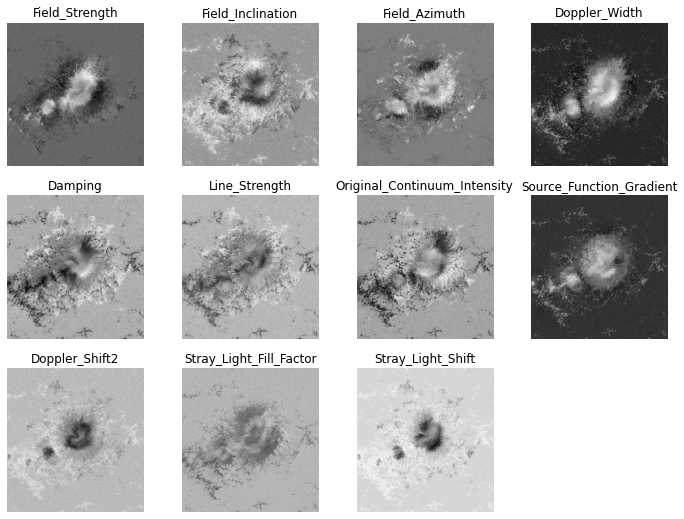

In [11]:
plot_params(predicted_mu)


### Model training on the entire dataset

In [6]:
params_full = fits.open('../data/parameters_base.fits')[0].data

In [7]:
full_model = Model(hps)

In [8]:
print("Number of training parameters:", sum(p.numel() for p in full_model.net.parameters() if p.requires_grad))

Number of training parameters: 641766


In [ ]:

# history = full_model.train(
#     data_arr=params_full[:10000],
#     logdir = '../logs/',
#     path_to_save='../models/pi_dist_mlp2.pt')

### Loading the trained model

In [9]:
full_model.load_model('../models/pi_dist_mlp.pt')

In [10]:
full_predicted_mu, full_predicted_sigma = full_model.predict_refer('../data/reference.fits')

Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


100%|██████████| 248/248 [00:33<00:00,  7.35it/s]


In [11]:
full_df_ind = compute_metrics(refer, full_predicted_mu, names, save_path = '../pi_dist_pred.csv')
full_df_ind

,r2,mse,mae
Field_Strength,0.899,0.002,0.025
Field_Inclination,0.894,0.003,0.023
Field_Azimuth,0.613,0.028,0.089
Doppler_Width,0.931,0.001,0.022
Damping,0.905,0.002,0.026
Line_Strength,0.549,0.009,0.042
Original_Continuum_Intensity,0.972,0.000,0.017
Source_Function_Gradient,0.986,0.000,0.011
Doppler_Shift2,0.869,0.000,0.009
Stray_Light_Fill_Factor,0.837,0.012,0.077


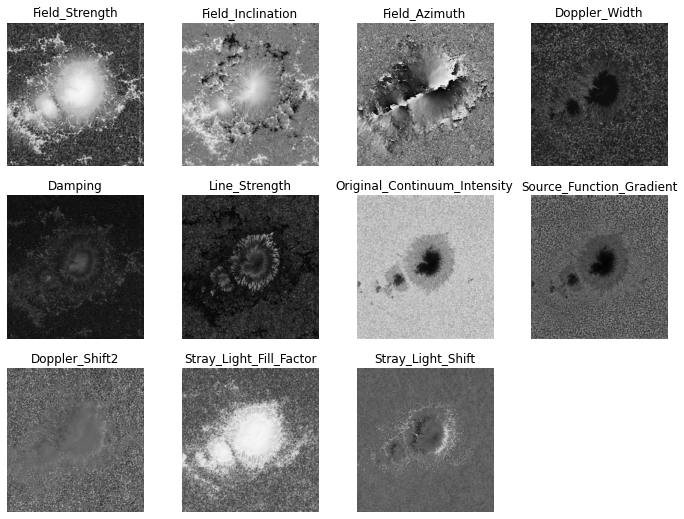

In [11]:
plot_params(full_predicted_mu)

### Plotting the results

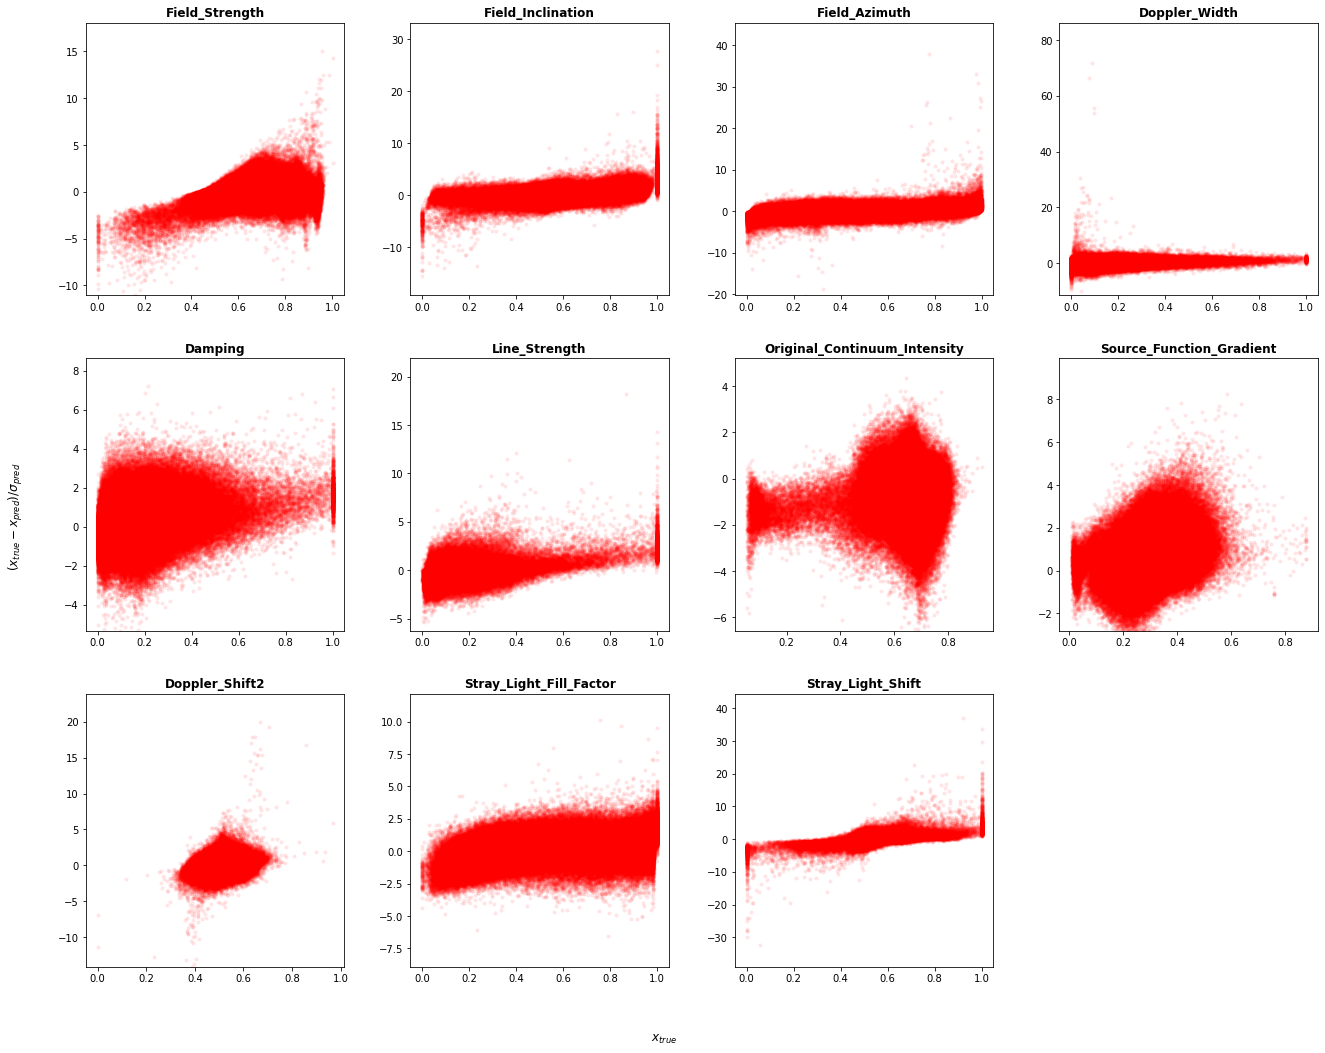

In [12]:
plot_2d(names, refer, full_predicted_mu, full_predicted_sigma, 0)

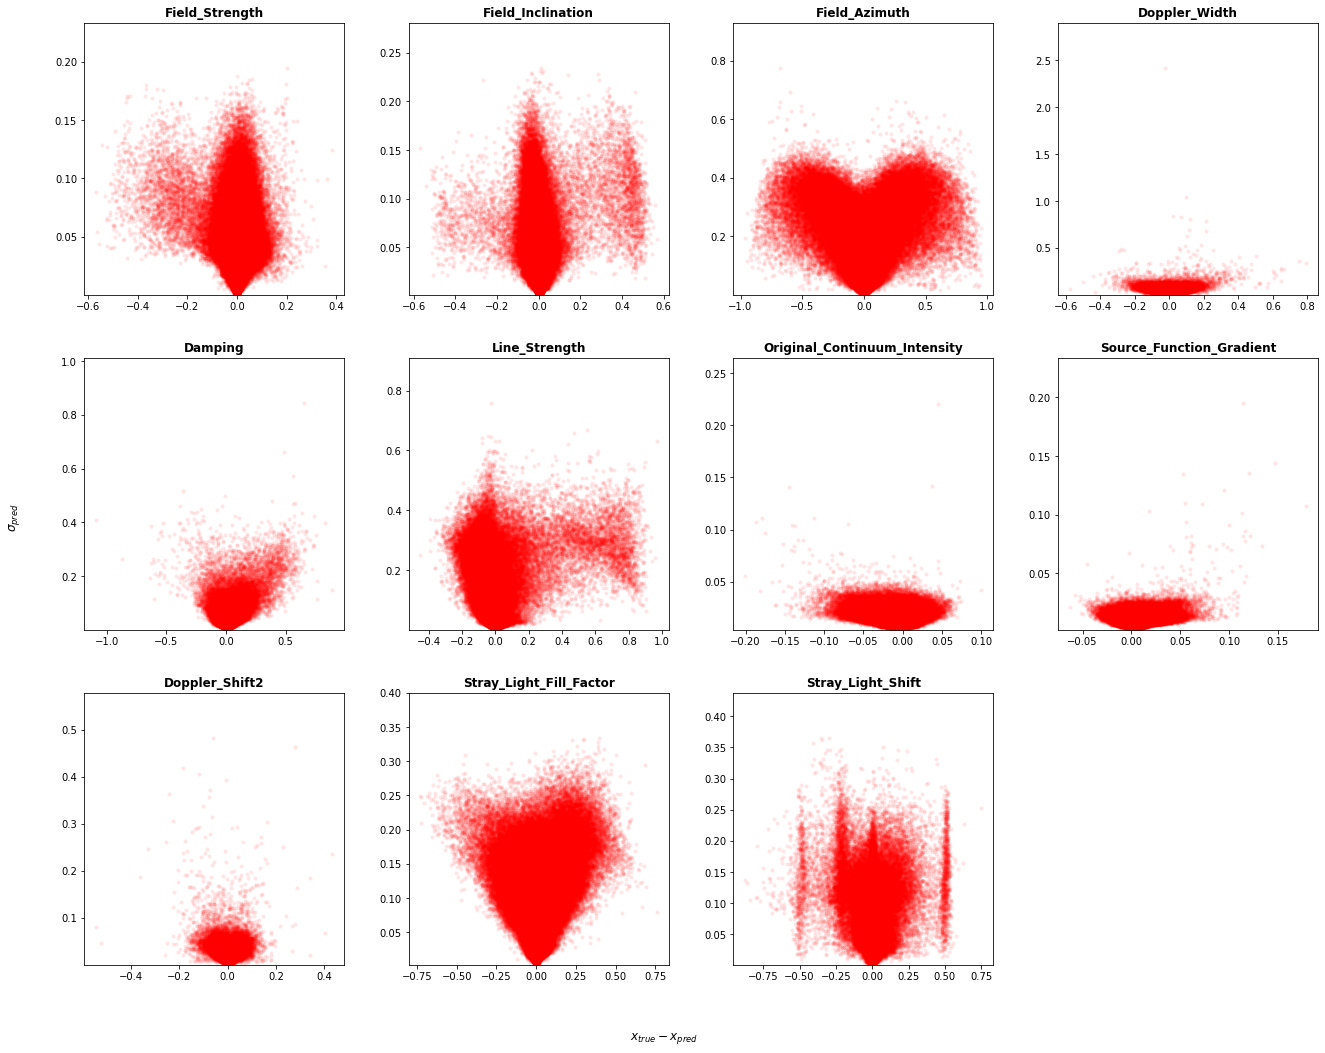

In [13]:
plot_2d(names, refer, full_predicted_mu, full_predicted_sigma, 1)

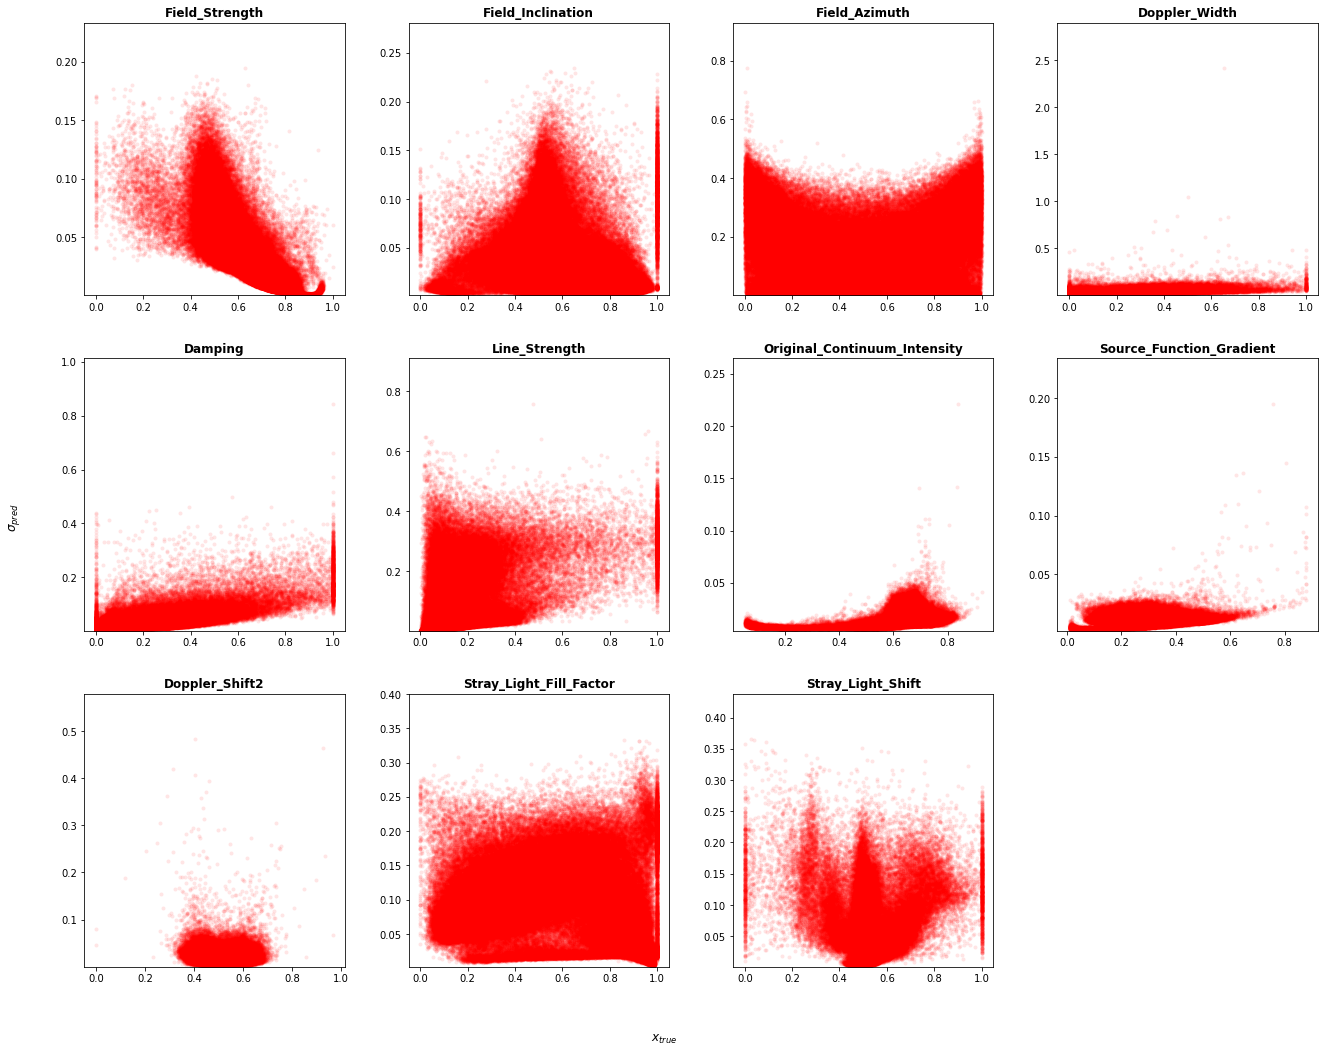

In [14]:
plot_2d(names, refer, full_predicted_mu, full_predicted_sigma, 2)

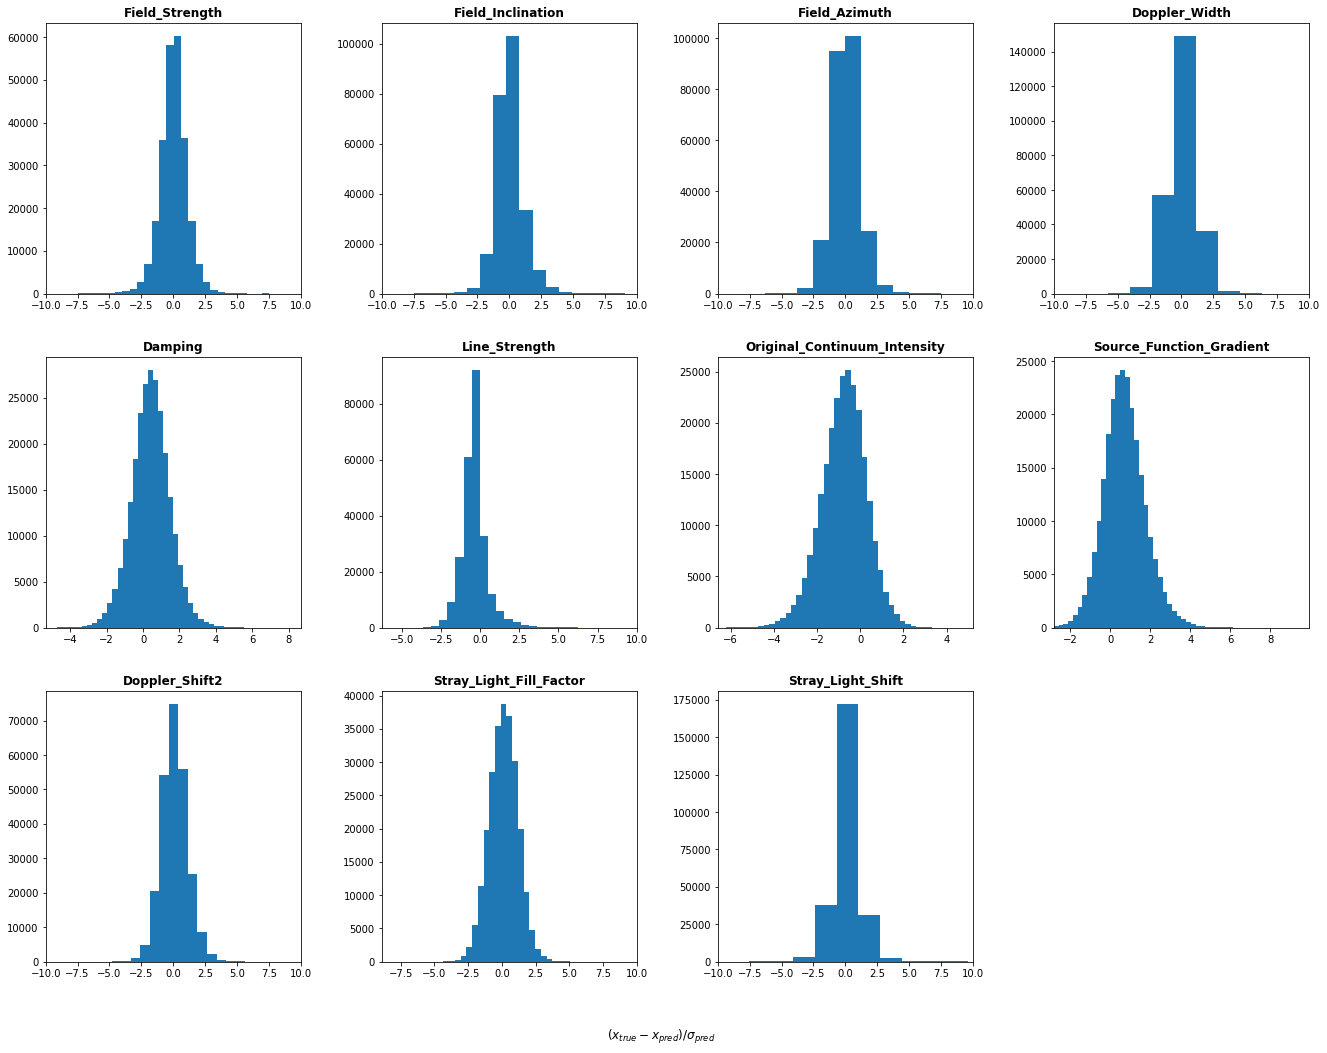

In [15]:
plot_1d(names, refer, full_predicted_mu, full_predicted_sigma, 50)